In [162]:
import os
import re
import glob
import numpy as np
import pandas as pd
import numpy as np
import scipy.io as sio
import spikeinterface.extractors as se
import spikeinterface as si
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
from pathlib import Path
import matplotlib.pyplot as plt
import json

from typing import List, Tuple

from scipy.stats import  pearsonr
import neo
from quantities import ms
from elephant.statistics import instantaneous_rate
from elephant.kernels import GaussianKernel
import seaborn as sns


from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


import numpy as np
from tensorly.decomposition import non_negative_parafac
import tensorly as tl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

In [344]:
CLUSTER_INFO_FILENAME = "cluster_info.tsv"

SPIKE_CLUSTERS_FILENAME = "spike_clusters.npy"
SPIKE_TIMES_FILENAME = "spike_times.npy"
SPIKE_POSITION_FILENAME = 'spike_positions.npy'

In [ ]:
def load_cluster_info(phy_dir: str) -> pd.DataFrame:
    """读取 phy_folder_for_kilosort/cluster_info.tsv 为 DataFrame。
    该表包含所有需要的 cluster 级指标。
    如果cluster_info.tsv不存在，则尝试从其他文件构建基本信息。
    同时计算并添加mean_waveform信息。
    """
    path = os.path.join(phy_dir, CLUSTER_INFO_FILENAME)
    
    if os.path.exists(path):
        df = pd.read_csv(path, sep='\t')
        # 标准化主键列名
        if 'cluster_id' not in df.columns:
            raise ValueError(f"{path} 中缺少 cluster_id 列")
    else:
        print(f"警告: {path} 不存在，尝试从其他文件构建cluster信息")
        
        # 尝试从cluster_group.tsv构建基本信息
        cluster_group_path = os.path.join(phy_dir, "cluster_group.tsv")
        if os.path.exists(cluster_group_path):
            df = pd.read_csv(cluster_group_path, sep='\t')
            if 'cluster_id' not in df.columns:
                raise ValueError(f"{cluster_group_path} 中缺少 cluster_id 列")
        else:
            # 如果都没有，从spike_clusters.npy中提取唯一的cluster_id
            spike_clusters_path = os.path.join(phy_dir, SPIKE_CLUSTERS_FILENAME)
            if os.path.exists(spike_clusters_path):
                spike_clusters = np.load(spike_clusters_path)
                unique_clusters = np.unique(spike_clusters)
                df = pd.DataFrame({
                    'cluster_id': unique_clusters,
                    'group': 'unsorted'  # 默认分组
                })
            else:
                raise ValueError(f"无法找到任何cluster信息文件: {phy_dir}")
    
    # 计算mean_waveform并展开为多列添加到DataFrame
    mean_waveforms = compute_mean_waveform(phy_dir)
    if mean_waveforms:
        # 确定waveform的长度（通常是90个时间点）
        waveform_length = None
        for waveform in mean_waveforms.values():
            if waveform is not None:
                waveform_length = len(waveform)
                break
        
        if waveform_length is not None:
            # 创建waveform列名
            waveform_columns = [f'mean_waveform_{i}' for i in range(waveform_length)]
            
            # 为每个cluster创建waveform数据
            waveform_data = {}
            for cluster_id in df['cluster_id']:
                if cluster_id in mean_waveforms and mean_waveforms[cluster_id] is not None:
                    waveform = mean_waveforms[cluster_id]
                    # 确保waveform长度一致
                    if len(waveform) == waveform_length:
                        waveform_data[cluster_id] = waveform
                    else:
                        # 如果长度不匹配，用NaN填充或截断
                        padded_waveform = np.full(waveform_length, np.nan)
                        padded_waveform[:min(len(waveform), waveform_length)] = waveform[:min(len(waveform), waveform_length)]
                        waveform_data[cluster_id] = padded_waveform
                else:
                    # 没有waveform数据的cluster用NaN填充
                    waveform_data[cluster_id] = np.full(waveform_length, np.nan)
            
            # 将waveform数据转换为DataFrame并合并
            waveform_df = pd.DataFrame.from_dict(waveform_data, orient='index', columns=waveform_columns)
            waveform_df.index.name = 'cluster_id'
            waveform_df = waveform_df.reset_index()
            
            # 合并到主DataFrame
            df = df.merge(waveform_df, on='cluster_id', how='left')
            print(f"成功添加mean_waveform信息到 {len(mean_waveforms)} 个clusters，展开为 {waveform_length} 列")
        else:
            print("警告: 无法确定waveform长度")
    else:
        print("警告: 无法计算mean_waveform信息")
    
    return df


def load_spike_level(phy_dir: str) -> pd.DataFrame:
    """读取 spike 层面的 numpy 文件并返回 DataFrame: [cluster, time]
    time 使用原始采样点，不做单位转换。
    """
    spike_clusters = np.load(os.path.join(phy_dir, SPIKE_CLUSTERS_FILENAME))
    spike_times = np.load(os.path.join(phy_dir, SPIKE_TIMES_FILENAME))

    spike_clusters = np.asarray(spike_clusters).reshape(-1)
    spike_times = np.asarray(spike_times).reshape(-1)

    if spike_clusters.shape[0] != spike_times.shape[0]:
        raise ValueError(f"spike_clusters 与 spike_times 行数不一致: {phy_dir}")
    df = pd.DataFrame({
        'cluster_id': spike_clusters.astype(int),
        'time': spike_times.astype(int),
    })
    return df


def compute_mean_waveform(phy_dir: str) -> dict:
    """计算每个cluster的平均波形
    
    Returns:
        dict: {cluster_id: mean_waveform_array}
    """
    templates_path = os.path.join(phy_dir, "templates.npy")
    spike_templates_path = os.path.join(phy_dir, "spike_templates.npy")
    spike_clusters_path = os.path.join(phy_dir, SPIKE_CLUSTERS_FILENAME)
    
    if not all(os.path.exists(p) for p in [templates_path, spike_templates_path, spike_clusters_path]):
        print("警告: 缺少计算waveform所需的文件，跳过mean_waveform计算")
        return {}
    
    # 加载数据
    templates = np.load(templates_path)  # shape: (n_templates, n_timepoints, n_channels)
    spike_templates = np.load(spike_templates_path).flatten()  # shape: (n_spikes,)
    spike_clusters = np.load(spike_clusters_path).flatten()  # shape: (n_spikes,)
    
    # 创建cluster到template的映射
    cluster_template_map = {}
    for spike_idx, (cluster_id, template_id) in enumerate(zip(spike_clusters, spike_templates)):
        if cluster_id not in cluster_template_map:
            cluster_template_map[cluster_id] = template_id
    
    # 计算每个cluster的mean_waveform
    mean_waveforms = {}
    for cluster_id, template_id in cluster_template_map.items():
        if template_id < templates.shape[0]:
            # 获取该cluster对应的template
            template = templates[template_id]  # shape: (n_timepoints, n_channels)
            # 如果模板是2D的，取第一个通道或平均所有通道
            if template.ndim == 2:
                if template.shape[1] == 1:
                    # 只有一个通道
                    mean_waveform = template[:, 0]
                else:
                    # 多个通道，取平均
                    mean_waveform = np.mean(template, axis=1)
            else:
                # 1D情况
                mean_waveform = template
            mean_waveforms[cluster_id] = mean_waveform
    
    return mean_waveforms

In [466]:
os.listdir("/media/ubuntu/sda/Memrisistor/sorted")

['251006-mouse4-treadmill-RHS_251006_111837',
 '251005-mouse3-treadmill-RHS_251005_175500',
 '251005-mouse5-treadmill-RHS_251005_162207',
 '251005-mouse1-treadmill-RHS_251005_172049',
 '251006-mouse3-treadmill-RHS_251006_103256',
 '251006-mouse5-treadmill-RHS_251006_120037']

In [468]:
for trial in ['251005-mouse3-treadmill-RHS_251005_175500']:
    ROOT_SORT_DIR = f"/media/ubuntu/sda/Memrisistor/sorted/{trial}/phy_folder_for_kilosort"
    cluster_inf = load_cluster_info(phy_dir=ROOT_SORT_DIR)
    spike_inf = load_spike_level(phy_dir=ROOT_SORT_DIR)

    cluster_inf = cluster_inf[cluster_inf['group'] == 'good']
    spike_inf = spike_inf[spike_inf['cluster_id'].isin(cluster_inf['cluster_id'].values)]

    running_epoch = spike_inf['time'].max() // (30 * 20000)
    start_time = []
    end_time = []
    state_list = []
    running_state = ['stop', 'running_1', 'running_2']
    for i in range(running_epoch):
        for state in range(3):
            start_time.append(20000 * 30 * i + state * 20000 * 10 + 1)
            end_time.append(20000 * 30 * i + state * 20000 * 10 + 200000)
            state_list.append(running_state[state])

    trigger_time = pd.DataFrame(start_time, columns=['start_time'])
    trigger_time['end_time'] = end_time
    trigger_time['state'] = state_list

    unique_neurons = spike_inf['cluster_id'].unique()
    gk = GaussianKernel(1000 * ms)
    trial_spike_rate_data = {}
    running_state = ['stop', 'running_1', 'running_2']
    trial_state = []
    trial_mean = []
    for state in running_state:
        trial_spike_rate_data[state] = []

    for idx, (_, row) in enumerate(trigger_time.iterrows()):

        start = row['start_time']
        end = row['end_time']
        state = row['state']
        
        neuron_data = []
        
        spike_inf_temp = spike_inf[(spike_inf['time'] >= start) & (spike_inf['time'] <= end)]

        for neuron in unique_neurons:
            valid_spikes = spike_inf_temp[spike_inf_temp['cluster_id'] == neuron]
            
            relative_spikes = (valid_spikes['time'] - start) / 20
            temp_spiketrain = neo.SpikeTrain(relative_spikes.values * ms, t_stop=10000, t_start=0)
            rates = instantaneous_rate(temp_spiketrain, kernel=gk, sampling_period=500*ms).magnitude.flatten()
            neuron_data.append(rates)
        
        trial_data = np.stack(neuron_data)
        trial_spike_rate_data[state].append(trial_data)
        trial_state.append(state)
        trial_mean.append(np.mean(trial_data, axis=1))

    trial_mean = np.stack(trial_mean)
    for state in running_state:
        trial_spike_rate_data[state] = np.stack(trial_spike_rate_data[state])

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)

    pca_result = pca.fit_transform(trial_mean)

    cluster_inf.to_csv(f"/media/ubuntu/sda/Memrisistor/results/cluster_inf_{trial}.csv", index=False)
    spike_inf.to_csv(f"/media/ubuntu/sda/Memrisistor/results/spike_inf_{trial}.csv", index=False)
    
    le = LabelEncoder()
    y = le.fit_transform(trial_state) 
    X = trial_mean  

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = SVC(kernel='rbf', C=1.0)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'SVM accuracy: {acc:.2f}')

    with PdfPages(f"/media/ubuntu/sda/Memrisistor/figure/classification_{trial}.pdf") as pdf:
        plt.figure(figsize=(5, 5))
        sns.scatterplot(x = pca_result[:, 0],
                y = pca_result[:, 1],
                hue = trial_state)
        plt.legend()
        pdf.savefig()
        plt.close()

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'SVM Confusion Matrix - Accuracy:{acc:.2f}')
        pdf.savefig()
        plt.close()

        all_trials = []
        trial_labels = []
        for state in trial_spike_rate_data:
            for trial in trial_spike_rate_data[state]:
                all_trials.append(trial)
                trial_labels.append(state)
        X_tensor = np.stack(all_trials) 

        rank = 10 
        weights, factors = non_negative_parafac(tl.tensor(X_tensor), rank=rank, init='random', n_iter_max=100)
        trial_features = factors[0]

        le = LabelEncoder()
        y = le.fit_transform(trial_labels)
        X = trial_features
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        clf = SVC(kernel='rbf', C=1.0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'NPF+SVM accuracy: {acc:.2f}')
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'NPF+SVM Confusion Matrix - Accuracy:{acc:.2f}')
        pdf.savefig()
        plt.close()


成功添加mean_waveform信息到 108 个clusters，展开为 60 列
SVM accuracy: 0.81
NPF+SVM accuracy: 0.92
SVM accuracy: 0.81
NPF+SVM accuracy: 0.92


In [472]:
ROOT_SORT_DIR_1 = f"/media/ubuntu/sda/Memrisistor/sorted/251005-mouse5-treadmill-RHS_251005_162207/phy_folder_for_kilosort"
cluster_inf_1 = load_cluster_info(phy_dir=ROOT_SORT_DIR_1)
spike_inf_1 = load_spike_level(phy_dir=ROOT_SORT_DIR_1)

cluster_inf_1['date'] = '100525'
spike_inf_1['date'] = '100525'

cluster_inf_1 = cluster_inf_1[cluster_inf_1['group'] == 'good']
spike_inf_1 = spike_inf_1[spike_inf_1['cluster_id'].isin(cluster_inf_1['cluster_id'].values)]

成功添加mean_waveform信息到 80 个clusters，展开为 60 列


In [473]:
ROOT_SORT_DIR_1 = f"/media/ubuntu/sda/Memrisistor/sorted/251006-mouse5-treadmill-RHS_251006_120037/phy_folder_for_kilosort"
cluster_inf_2 = load_cluster_info(phy_dir=ROOT_SORT_DIR_1)
spike_inf_2 = load_spike_level(phy_dir=ROOT_SORT_DIR_1)

cluster_inf_2['date'] = '100625'
spike_inf_2['date'] = '100625'

cluster_inf_2 = cluster_inf_2[cluster_inf_2['group'] == 'good']
spike_inf_2 = spike_inf_2[spike_inf_2['cluster_id'].isin(cluster_inf_2['cluster_id'].values)]

成功添加mean_waveform信息到 78 个clusters，展开为 60 列


In [474]:
cluster_inf = pd.concat((cluster_inf_1, cluster_inf_2), axis=0)
spike_inf = pd.concat((spike_inf_1, spike_inf_2), axis=0)

In [475]:
from scipy.stats import pearsonr


unique_dates = cluster_inf['date'].unique()
assert len(unique_dates) == 2, '仅支持两个日期的匹配'
df1 = cluster_inf[cluster_inf['date'] == unique_dates[0]].copy()
df2 = cluster_inf[cluster_inf['date'] == unique_dates[1]].copy()

waveform_cols = [col for col in cluster_inf.columns if col.startswith('mean_waveform_')]

match_results = []
for idx1, row1 in df1.iterrows():
    for idx2, row2 in df2.iterrows():
        if row1['ch'] == row2['ch']:
            w1 = row1[waveform_cols].values.astype(float)
            w2 = row2[waveform_cols].values.astype(float)
            if np.all(np.isfinite(w1)) and np.all(np.isfinite(w2)):
                corr, _ = pearsonr(w1, w2)
                if corr > 0.95:
                    match_results.append({
                        'date1': row1['date'], 'cluster1': row1['cluster_id'],
                        'date2': row2['date'], 'cluster2': row2['cluster_id'],
                        'channel': row1['ch'], 'pearson': corr
                    })

matched = pd.DataFrame(match_results)
matched['Neuron'] = ['Neuron_%d' % (i+1) for i in range(len(matched))]

cluster_inf['Neuron'] = None
for _, row in matched.iterrows():
    mask1 = (cluster_inf['date'] == row['date1']) & (cluster_inf['cluster_id'] == row['cluster1'])
    mask2 = (cluster_inf['date'] == row['date2']) & (cluster_inf['cluster_id'] == row['cluster2'])
    cluster_inf.loc[mask1, 'Neuron'] = row['Neuron']
    cluster_inf.loc[mask2, 'Neuron'] = row['Neuron']

cluster_inf = cluster_inf.dropna(subset=['Neuron'])

In [476]:
remained_neuron = cluster_inf['Neuron'].value_counts()
remained_neuron = remained_neuron[remained_neuron > 1].index

cluster_inf = cluster_inf[cluster_inf['Neuron'].isin(remained_neuron)]
cluster_inf['cluster_date'] = cluster_inf['cluster_id'].astype(str) + cluster_inf['date']
spike_inf['cluster_date'] = spike_inf['cluster_id'].astype(str) + spike_inf['date']

spike_inf = spike_inf[spike_inf['cluster_date'].isin(cluster_inf['cluster_date'].unique())]

In [477]:
#1005
cluster_inf_temp = cluster_inf[cluster_inf['date'] == '100525']
spike_inf_1005 = spike_inf[spike_inf['date'] == '100525']

running_epoch = spike_inf_1005['time'].max() // (30 * 20000)
start_time = []
end_time = []
state_list = []
running_state = ['stop', 'running_1', 'running_2']
for i in range(running_epoch):
    for state in range(3):
        start_time.append(20000 * 30 * i + state * 20000 * 10 + 1)
        end_time.append(20000 * 30 * i + state * 20000 * 10 + 200000)
        state_list.append(running_state[state])

trigger_time = pd.DataFrame(start_time, columns=['start_time'])
trigger_time['end_time'] = end_time
trigger_time['state'] = state_list

unique_neurons = spike_inf_1005['cluster_id'].unique()
gk = GaussianKernel(1000 * ms)
trial_spike_rate_data_1005 = {}
running_state = ['stop', 'running_1', 'running_2']
trial_state = []
trial_mean_1005 = []
for state in running_state:
    trial_spike_rate_data_1005[state] = []

for idx, (_, row) in enumerate(trigger_time.iterrows()):

    start = row['start_time']
    end = row['end_time']
    state = row['state']
    
    neuron_data = []
    
    spike_inf_temp = spike_inf[(spike_inf['time'] >= start) & (spike_inf['time'] <= end)]

    for neuron in unique_neurons:
        valid_spikes = spike_inf_temp[spike_inf_temp['cluster_id'] == neuron]
        
        relative_spikes = (valid_spikes['time'] - start) / 20
        temp_spiketrain = neo.SpikeTrain(relative_spikes.values * ms, t_stop=10000, t_start=0)
        rates = instantaneous_rate(temp_spiketrain, kernel=gk, sampling_period=500*ms).magnitude.flatten()
        neuron_data.append(rates)
    
    trial_data = np.stack(neuron_data)
    trial_spike_rate_data_1005[state].append(trial_data)
    trial_state.append(state)
    trial_mean_1005.append(np.mean(trial_data, axis=1))

trial_mean_1005 = np.stack(trial_mean_1005)
for state in running_state:
    trial_spike_rate_data_1005[state] = np.stack(trial_spike_rate_data_1005[state])

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(trial_mean_1005)

In [478]:
le = LabelEncoder()
y = le.fit_transform(trial_state) 
X = trial_mean_1005  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = SVC(kernel='rbf', C=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'SVM accuracy: {acc:.2f}')

with PdfPages(f"/media/ubuntu/sda/Memrisistor/figure/classification_mouse5_1005.pdf") as pdf:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x = pca_result[:, 0],
            y = pca_result[:, 1],
            hue = trial_state)
    plt.legend()
    pdf.savefig()
    plt.close()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'SVM Confusion Matrix - Accuracy:{acc:.2f}')
    pdf.savefig()
    plt.close()

    all_trials = []
    trial_labels = []
    for state in trial_spike_rate_data_1005:
        for trial in trial_spike_rate_data_1005[state]:
            all_trials.append(trial)
            trial_labels.append(state)
    X_tensor = np.stack(all_trials) 

    rank = 15 
    weights, factors = non_negative_parafac(tl.tensor(X_tensor), rank=rank, init='random', n_iter_max=100)
    trial_features = factors[0]

    le = LabelEncoder()
    y = le.fit_transform(trial_labels)
    X = trial_features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = SVC(kernel='rbf', C=1.0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'NPF+SVM accuracy: {acc:.2f}')
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'NPF+SVM Confusion Matrix - Accuracy:{acc:.2f}')
    pdf.savefig()
    plt.close()


SVM accuracy: 0.49
NPF+SVM accuracy: 0.78


In [479]:
#1006
cluster_inf_temp = cluster_inf[cluster_inf['date'] == '100625']
spike_inf_1006 = spike_inf[spike_inf['date'] == '100625']

running_epoch = spike_inf_1006['time'].max() // (30 * 20000)
start_time = []
end_time = []
state_list = []
running_state = ['stop', 'running_1', 'running_2']
for i in range(running_epoch):
    for state in range(3):
        start_time.append(20000 * 30 * i + state * 20000 * 10 + 1)
        end_time.append(20000 * 30 * i + state * 20000 * 10 + 200000)
        state_list.append(running_state[state])

trigger_time = pd.DataFrame(start_time, columns=['start_time'])
trigger_time['end_time'] = end_time
trigger_time['state'] = state_list

unique_neurons = spike_inf_1006['cluster_id'].unique()
gk = GaussianKernel(1000 * ms)
trial_spike_rate_data_1006 = {}
running_state = ['stop', 'running_1', 'running_2']
trial_state = []
trial_mean = []
for state in running_state:
    trial_spike_rate_data_1006[state] = []

for idx, (_, row) in enumerate(trigger_time.iterrows()):

    start = row['start_time']
    end = row['end_time']
    state = row['state']
    
    neuron_data = []
    
    spike_inf_temp = spike_inf[(spike_inf['time'] >= start) & (spike_inf['time'] <= end)]

    for neuron in unique_neurons:
        valid_spikes = spike_inf_temp[spike_inf_temp['cluster_id'] == neuron]
        
        relative_spikes = (valid_spikes['time'] - start) / 20
        temp_spiketrain = neo.SpikeTrain(relative_spikes.values * ms, t_stop=10000, t_start=0)
        rates = instantaneous_rate(temp_spiketrain, kernel=gk, sampling_period=500*ms).magnitude.flatten()
        neuron_data.append(rates)
    
    trial_data = np.stack(neuron_data)
    trial_spike_rate_data_1006[state].append(trial_data)
    trial_state.append(state)
    trial_mean.append(np.mean(trial_data, axis=1))

trial_mean = np.stack(trial_mean)
for state in running_state:
    trial_spike_rate_data_1006[state] = np.stack(trial_spike_rate_data_1006[state])

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(trial_mean)

In [480]:
le = LabelEncoder()
y = le.fit_transform(trial_state) 
X = trial_mean  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = SVC(kernel='rbf', C=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'SVM accuracy: {acc:.2f}')

with PdfPages(f"/media/ubuntu/sda/Memrisistor/figure/classification_mouse5_1006.pdf") as pdf:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x = pca_result[:, 0],
            y = pca_result[:, 1],
            hue = trial_state)
    plt.legend()
    pdf.savefig()
    plt.close()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'SVM Confusion Matrix - Accuracy:{acc:.2f}')
    pdf.savefig()
    plt.close()

    all_trials = []
    trial_labels = []
    for state in trial_spike_rate_data_1006:
        for trial in trial_spike_rate_data_1006[state]:
            all_trials.append(trial)
            trial_labels.append(state)
    X_tensor = np.stack(all_trials) 

    rank = 15 
    weights, factors = non_negative_parafac(tl.tensor(X_tensor), rank=rank, init='random', n_iter_max=100)
    trial_features = factors[0]

    le = LabelEncoder()
    y = le.fit_transform(trial_labels)
    X = trial_features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = SVC(kernel='rbf', C=1.0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'NPF+SVM accuracy: {acc:.2f}')
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'NPF+SVM Confusion Matrix - Accuracy:{acc:.2f}')
    pdf.savefig()
    plt.close()

SVM accuracy: 0.79
NPF+SVM accuracy: 0.95


In [495]:
X_1005.shape

(270, 15)

In [496]:
X_1006.shape

(189, 15)

用1005的NPF+SVM模型预测1006准确率: 0.61


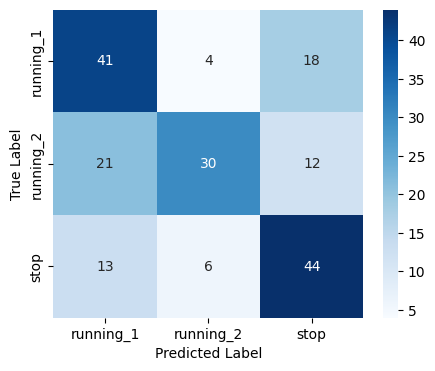

In [576]:

trial_labels_1005 = []
all_trials_1005 = []
for state in trial_spike_rate_data_1005:
    for trial in trial_spike_rate_data_1005[state]:
        all_trials_1005.append(trial)
        trial_labels_1005.append(state)
X_tensor_1005 = np.stack(all_trials_1005)
rank = 8
weights_1005, factors_1005 = non_negative_parafac(tl.tensor(X_tensor_1005), rank=rank, init='random', n_iter_max=100)
trial_features_1005 = factors_1005[0]

le_1005 = LabelEncoder()
y_1005 = le_1005.fit_transform(trial_labels_1005)
X_1005 = trial_features_1005

clf_1005 = SVC(kernel='rbf', C=1.0)
clf_1005.fit(X_1005, y_1005)

trial_labels_1006 = []
all_trials_1006 = []
for state in trial_spike_rate_data_1006:
    for trial in trial_spike_rate_data_1006[state]:
        all_trials_1006.append(trial)
        trial_labels_1006.append(state)
X_tensor_1006 = np.stack(all_trials_1006)
weights_1006, factors_1006 = non_negative_parafac(tl.tensor(X_tensor_1006), rank=rank, init='random', n_iter_max=100)
trial_features_1006 = factors_1006[0]

le_1006 = LabelEncoder()
y_1006 = le_1006.fit_transform(trial_labels_1006)
X_1006 = trial_features_1006

y_pred_1006 = clf_1005.predict(X_1006)
acc_1006 = accuracy_score(y_1006, y_pred_1006)
print(f'用1005的NPF+SVM模型预测1006准确率: {acc_1006:.2f}')
cm_1006 = confusion_matrix(y_1006, y_pred_1006)
plt.figure(figsize=(5,4))
sns.heatmap(cm_1006, annot=True, fmt='d', cmap='Blues', xticklabels=le_1006.classes_, yticklabels=le_1006.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

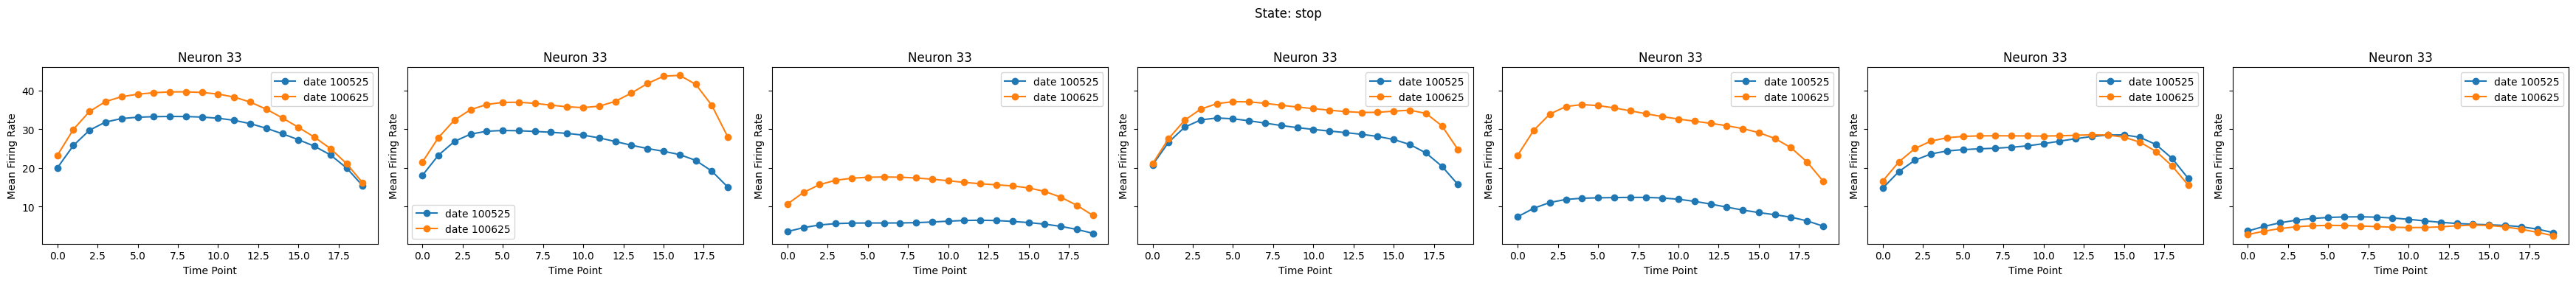

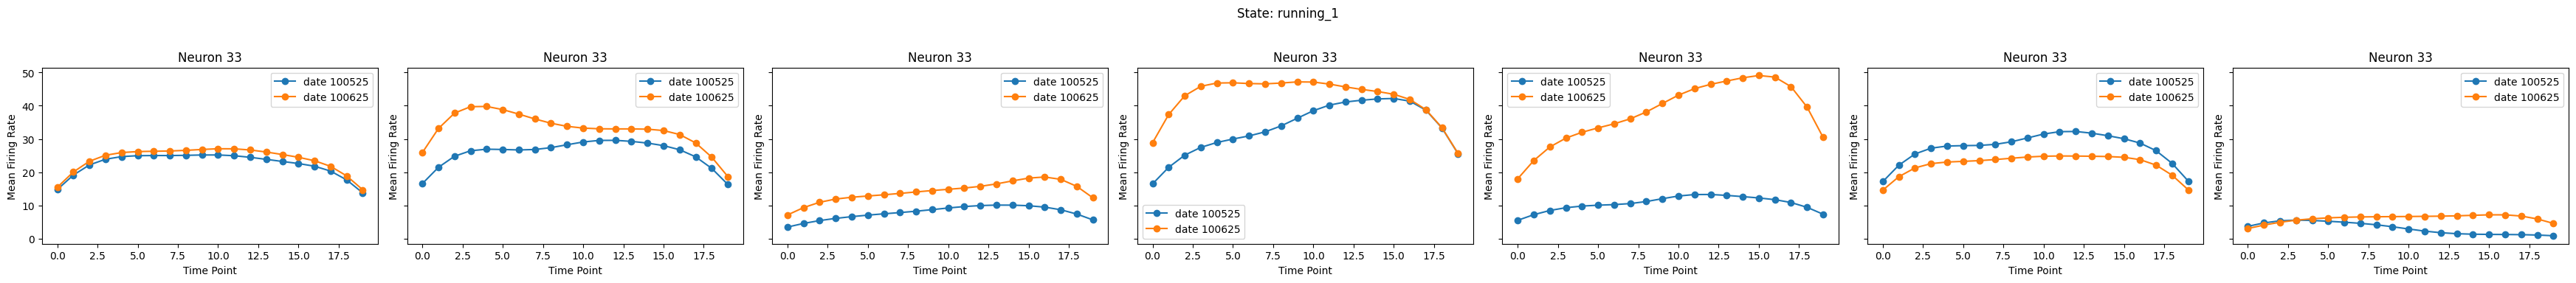

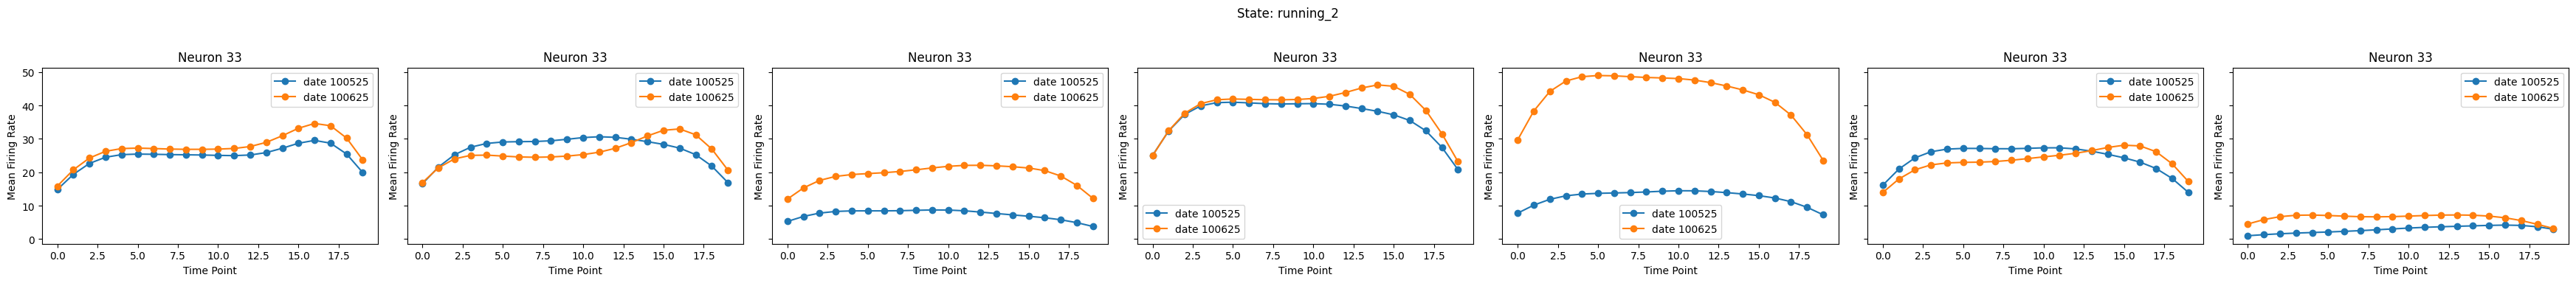

In [577]:
dates = cluster_inf['date'].unique()
state_names = ['stop', 'running_1', 'running_2']
neurons = cluster_inf['Neuron'].unique()

for state in state_names:
    fig, axes = plt.subplots(1, len(neurons), figsize=(5*len(neurons), 4), sharey=True)
    for i in range(len(neurons)):
        for j, date in enumerate(dates):
            if date == dates[0]:
                trials = trial_spike_rate_data_1005[state] 
            else:
                trials = trial_spike_rate_data_1006[state]
            
            mean_firing_rate = trials[:, i, :].mean(axis=0)
            axes[i].plot(np.arange(len(mean_firing_rate)), mean_firing_rate, marker='o', label=f'date {date}')
        axes[i].set_title(f'Neuron {neuron}')
        axes[i].set_xlabel('Time Point')
        axes[i].set_ylabel('Mean Firing Rate')
        axes[i].legend()
    fig.suptitle(f'State: {state}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

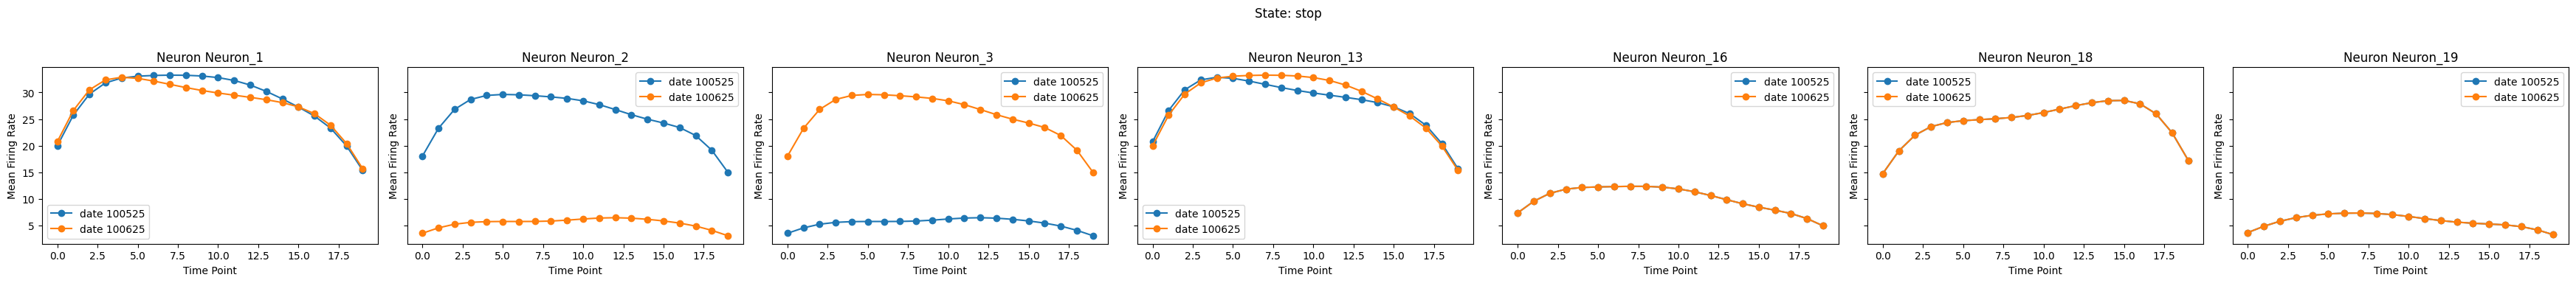

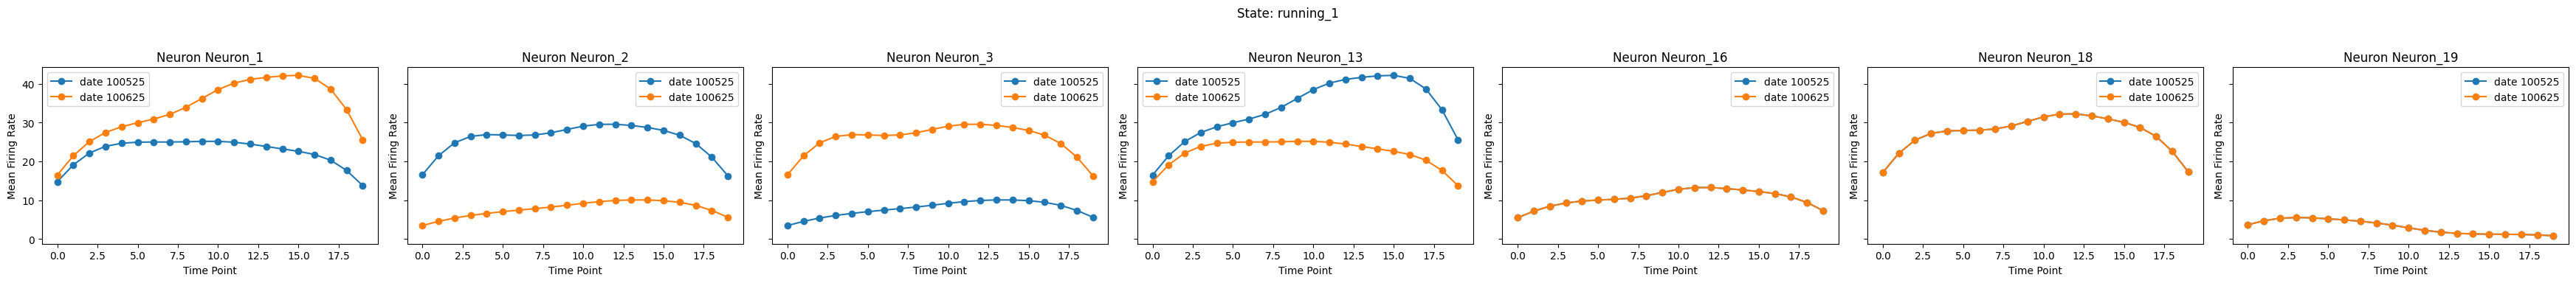

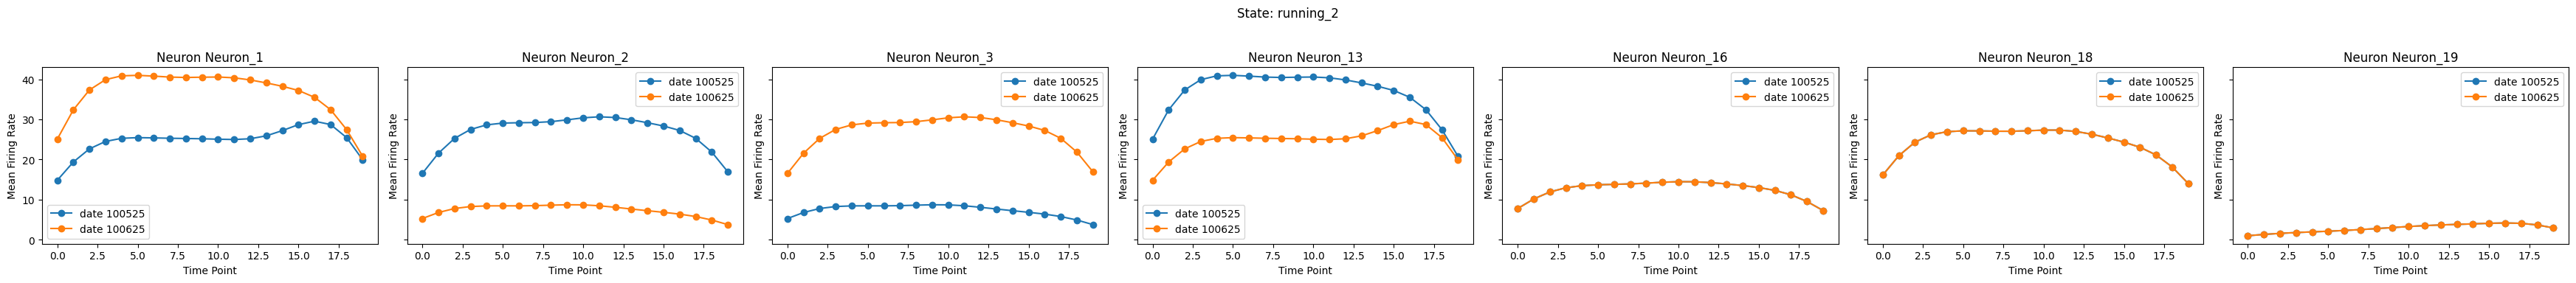

In [464]:
# 按照运动状态绘制三张图，每张图有7个子图，每个子图代表一个neuron，横坐标为日期，纵坐标为该neuron在该状态下的20个时间点的mean firing rate（每个点为一个trial的均值再对所有trial取均值）
import matplotlib.pyplot as plt
import numpy as np

neurons = cluster_inf['Neuron'].unique()
dates = cluster_inf['date'].unique()
state_names = ['stop', 'running_1', 'running_2']

for state in state_names:
    fig, axes = plt.subplots(1, len(neurons), figsize=(5*len(neurons), 4), sharey=True)
    if len(neurons) == 1:
        axes = [axes]
    for i, neuron in enumerate(neurons):
        # 每个日期下该neuron的20个时间点的mean firing rate
        for j, date in enumerate(dates):
            cluster_ids = cluster_inf[(cluster_inf['Neuron'] == neuron) & (cluster_inf['date'] == date)]['cluster_id'].values
            if len(cluster_ids) == 0:
                axes[i].plot([], [], label=f'date {date}')
                continue
            if date == dates[0]:
                trials = trial_spike_rate_data_1005[state] # shape: (n_trials, n_neurons, n_time)
            else:
                trials = trial_spike_rate_data_1006[state]
            neuron_idx = np.where(cluster_inf[(cluster_inf['date'] == date)]['Neuron'].unique() == neuron)[0][0]
            # 取所有trial该neuron的 firing rate，shape: (n_trials, n_time)
            neuron_trials = np.array([trial[neuron_idx] for trial in trials]) # (n_trials, n_time)
            # 对所有trial在每个时间点取均值，得到 (n_time,)
            mean_firing_rate = neuron_trials.mean(axis=0)
            axes[i].plot(np.arange(len(mean_firing_rate)), mean_firing_rate, marker='o', label=f'date {date}')
        axes[i].set_title(f'Neuron {neuron}')
        axes[i].set_xlabel('Time Point')
        axes[i].set_ylabel('Mean Firing Rate')
        axes[i].legend()
    fig.suptitle(f'State: {state}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()